# Frame element Response

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import openseespy.opensees as ops

import opstool as opst

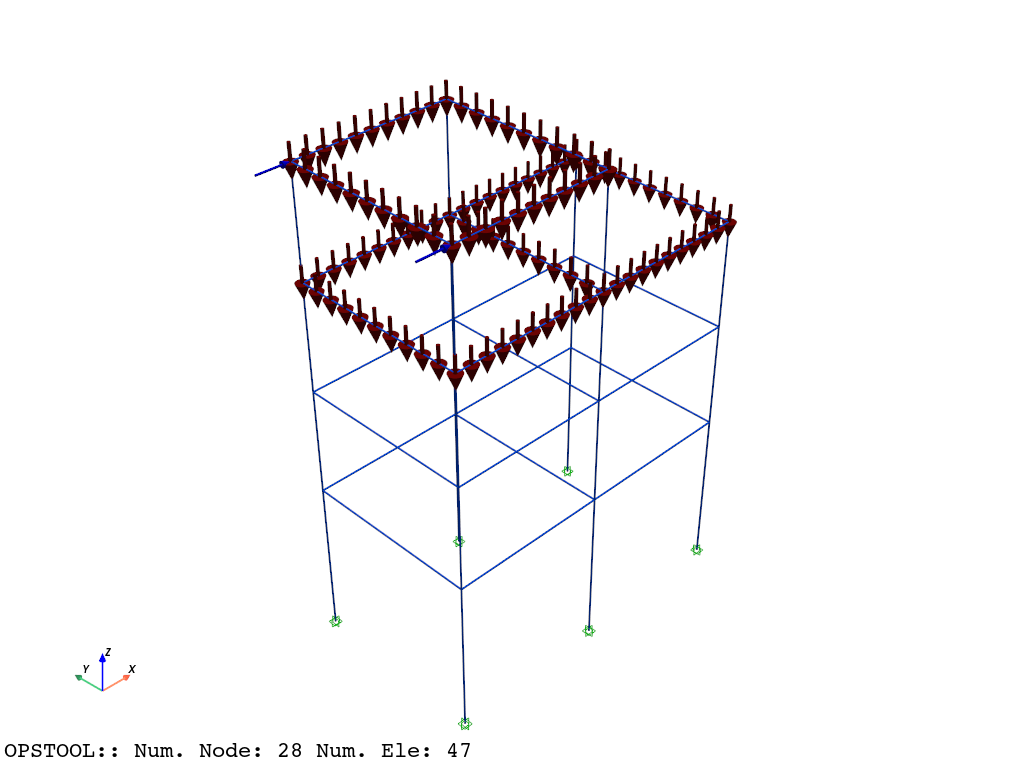

In [2]:
opst.load_ops_examples("Frame3D2")  # or your model code here

# add beam loads
ops.timeSeries("Linear", 1)
ops.pattern("Plain", 1, 1)
ops.load(6, 10, 0.0, 0.0, 0.0, 0.0, 0.0)
ops.load(8, 10, 0.0, 0.0, 0.0, 0.0, 0.0)
for etag in [5, 6, 7, 8, 15, 16, 17, 18, 19, 20, 21]:
    ops.eleLoad("-ele", etag, "-type", "-beamUniform", 0.0, -10)

# plot
opst.vis.pyvista.set_plot_props(notebook=True)
fig = opst.vis.pyvista.plot_model(show_nodal_loads=True, show_ele_loads=True)
fig.show(jupyter_backend="static")

## Result Saving

In [3]:
ops.system("BandGeneral")
# Create the constraint handler, the transformation method
ops.constraints("Transformation")
# Create the DOF numberer, the reverse Cuthill-McKee algorithm
ops.numberer("RCM")
# Create the convergence test, the norm of the residual with a tolerance of
# 1e-12 and a max number of iterations of 10
ops.test("NormDispIncr", 1.0e-12, 10, 3)
# Create the solution algorithm, a Newton-Raphson algorithm
ops.algorithm("Newton")
# Create the integration scheme, the LoadControl scheme using steps of 0.1
ops.integrator("LoadControl", 0.1)
# Create the analysis object
ops.analysis("Static")

In [4]:
ODB = opst.post.CreateODB(odb_tag=1, elastic_frame_sec_points=9)
for i in range(10):
    ops.analyze(1)
    ODB.fetch_response_step()
ODB.save_response()

OPSTOOL ::  All responses data with _odb_tag = 1 saved in .opstool.output/RespStepData-1.nc!

## Result Reading

In [5]:
all_resp = opst.post.get_element_responses(odb_tag=1, ele_type="Frame")

OPSTOOL ::  Loading Frame response data from .opstool.output/RespStepData-1.nc ...

The result is an ``xarray DataSet`` object, and we can access the associated DataArray objects through ``.data_vars``.

In [6]:
all_resp.data_vars

Data variables:
    localForces          (time, eleTags, localDofs) float32 25kB 0.0 ... 89.87
    basicForces          (time, eleTags, basicDofs) float32 12kB 0.0 ... -1.6...
    basicDeformations    (time, eleTags, basicDofs) float32 12kB 0.0 ... -2.0...
    plasticDeformation   (time, eleTags, basicDofs) float32 12kB 0.0 0.0 ... 0.0
    sectionForces        (time, eleTags, secPoints, secDofs) float32 112kB -0...
    sectionDeformations  (time, eleTags, secPoints, secDofs) float32 112kB 0....
    sectionLocs          (time, eleTags, secPoints, locs) float32 74kB 0.0 .....

The ``variable names``, along with their ``dimensions`` and ``coordinates``, are displayed above.
The first four represent the resistance and deformation at both ends of the element, while the last three are quantities related to the cross-section.

In [18]:
print(all_resp["basicForces"])

<xarray.DataArray 'basicForces' (time: 11, eleTags: 47, basicDofs: 6)> Size: 12kB
array([[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
          0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
          0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
          0.0000000e+00,  0.0000000e+00],
        ...,
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
          0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
          0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
          0.0000000e+00,  0.0000000e+00]],

       [[-4.7502593e+03,  1.0951276e+06,  1.3049659e+06,  5.8833088e+05,
          1.1357798e+06,  3.8410974e+02],
        [-4.7502593e+03, -1.0951276e+06, -1.3049659e+06,  5.8833088e+05,
          1.1357798e+06, 

In [8]:
all_resp.attrs

{'localDofs': 'local coord system dofs at end 1 and end 2',
 'basicDofs': 'basic coord system dofs at end 1 and end 2',
 'secPoints': 'section points No.',
 'secDofs': 'section forces and deformations Dofs. Note that the section DOFs are only valid for <Elastic Section>, <Elastic Shear Section>, and <Fiber Section>. For <Aggregator Section>, you should carefully check the data, as it may not correspond directly to the DOFs.',
 'Notes': 'Note that the deformations are displacements and rotations in the basicDofs;And strains and curvatures in the secDofs'}

### Section response

Sometimes we are more concerned with the response at the section level, which can be easily extracted.
For example, extracting section forces involves four dimensions: ``time (time)``, ``element IDs (eleTags)``, ``section locations (secLocs)``, and ``degrees of freedom (secDoFs)``.

In [19]:
sec_forces = all_resp["sectionForces"]
sec_defos = all_resp["sectionDeformations"]

In [10]:
sec_locs = all_resp["sectionLocs"].sel(eleTags=6, time=0)
sec_locs

<xarray.DataArray 'sectionLocs' (secPoints: 9, locs: 4)> Size: 144B
array([[0.000e+00, 4.500e+03, 0.000e+00, 1.350e+04],
       [1.250e-01, 4.500e+03, 6.250e+02, 1.350e+04],
       [2.500e-01, 4.500e+03, 1.250e+03, 1.350e+04],
       [3.750e-01, 4.500e+03, 1.875e+03, 1.350e+04],
       [5.000e-01, 4.500e+03, 2.500e+03, 1.350e+04],
       [6.250e-01, 4.500e+03, 3.125e+03, 1.350e+04],
       [7.500e-01, 4.500e+03, 3.750e+03, 1.350e+04],
       [8.750e-01, 4.500e+03, 4.375e+03, 1.350e+04],
       [1.000e+00, 4.500e+03, 5.000e+03, 1.350e+04]], dtype=float32)
Coordinates:
    time       float64 8B 0.0
    eleTags    int32 4B 6
  * secPoints  (secPoints) int32 36B 1 2 3 4 5 6 7 8 9
  * locs       (locs) <U5 80B 'alpha' 'X' 'Y' 'Z'

We can select the response of multiple elements. 
``.isel(time=-1)`` is used to retrieve the data at the last time step, where ``.isel`` means indexing by position.

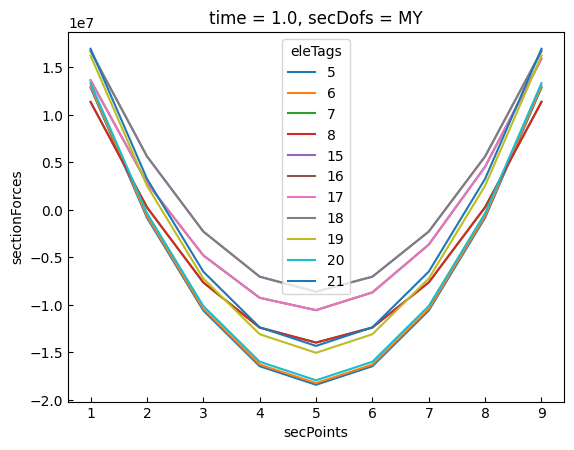

In [ ]:
sec_forces_my = sec_forces.sel(
    eleTags=[5, 6, 7, 8, 15, 16, 17, 18, 19, 20, 21],
    secDofs="MY",
).isel(time=-1)
# sec_forces_my.coords["secPoints"] = sec_locs

# plot
sec_forces_my.plot.line(x="secPoints")
plt.show()

Here, we retrieve the moment about the local y-axis for element 6:

Note: ``.sel`` is the abbreviation for "select".

In [12]:
sec_forces_my = sec_forces.sel(eleTags=6, secDofs="MY")
sec_forces_my

<xarray.DataArray 'sectionForces' (time: 11, secPoints: 9)> Size: 396B
array([[        0.  ,         0.  ,         0.  ,         0.  ,
                0.  ,         0.  ,         0.  ,         0.  ,
                0.  ],
       [  1302830.2 ,    -64357.25,  -1040919.75,  -1626857.2 ,
         -1822169.8 ,  -1626857.2 ,  -1040919.75,    -64357.25,
          1302830.2 ],
       [  2605660.5 ,   -128714.5 ,  -2081839.5 ,  -3253714.5 ,
         -3644339.5 ,  -3253714.5 ,  -2081839.5 ,   -128714.5 ,
          2605660.5 ],
       [  3908490.8 ,   -193071.75,  -3122759.2 ,  -4880571.5 ,
         -5466509.  ,  -4880571.5 ,  -3122759.2 ,   -193071.75,
          3908490.8 ],
       [  5211321.  ,   -257429.  ,  -4163679.  ,  -6507429.  ,
         -7288679.  ,  -6507429.  ,  -4163679.  ,   -257429.  ,
          5211321.  ],
       [  6514151.5 ,   -321786.  ,  -5204598.5 ,  -8134286.  ,
         -9110848.  ,  -8134286.  ,  -5204598.5 ,   -321786.  ,
          6514151.5 ],
       [  7816981.5 ,   -386143.5 ,  -6245518.5 ,  -9761144.  ,
        -10933018.  ,  -9761144.  ,  -6245518.5 ,   -386143.5 ,
          7816981.5 ],
       [  9119812.  ,   -450500.5 ,  -7286438.  , -11388000.  ,
        -12755188.  , -11388000.  ,  -7286438.  ,   -450500.5 ,
          9119812.  ],
       [ 10422642.  ,   -514858.  ,  -8327358.  , -13014858.  ,
        -14577358.  , -13014858.  ,  -8327358.  ,   -514858.  ,
         10422642.  ],
       [ 11725472.  ,   -579215.5 ,  -9368278.  , -14641716.  ,
        -16399528.  , -14641716.  ,  -9368278.  ,   -579215.5 ,
         11725472.  ],
       [ 13028303.  ,   -643572.  , -10409197.  , -16268572.  ,
        -18221698.  , -16268572.  , -10409197.  ,   -643572.  ,
         13028303.  ]], dtype=float32)
Coordinates:
  * time       (time) float64 88B 0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0
    eleTags    int32 4B 6
  * secPoints  (secPoints) int32 36B 1 2 3 4 5 6 7 8 9
    secDofs    <U2 8B 'MY'

We can plot the moment at different section locations for various time steps.

In [13]:
sec_locs

<xarray.DataArray 'sectionLocs' (secPoints: 9, locs: 4)> Size: 144B
array([[0.000e+00, 4.500e+03, 0.000e+00, 1.350e+04],
       [1.250e-01, 4.500e+03, 6.250e+02, 1.350e+04],
       [2.500e-01, 4.500e+03, 1.250e+03, 1.350e+04],
       [3.750e-01, 4.500e+03, 1.875e+03, 1.350e+04],
       [5.000e-01, 4.500e+03, 2.500e+03, 1.350e+04],
       [6.250e-01, 4.500e+03, 3.125e+03, 1.350e+04],
       [7.500e-01, 4.500e+03, 3.750e+03, 1.350e+04],
       [8.750e-01, 4.500e+03, 4.375e+03, 1.350e+04],
       [1.000e+00, 4.500e+03, 5.000e+03, 1.350e+04]], dtype=float32)
Coordinates:
    time       float64 8B 0.0
    eleTags    int32 4B 6
  * secPoints  (secPoints) int32 36B 1 2 3 4 5 6 7 8 9
  * locs       (locs) <U5 80B 'alpha' 'X' 'Y' 'Z'

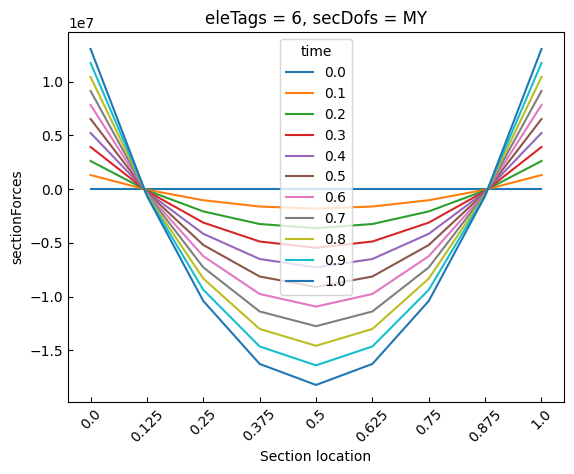

In [14]:
times = np.linspace(0, 1, 11)
sec_forces_my.coords["time"] = [f"{d:.1f}" for d in times]

# plot
sec_forces_my.plot.line(x="secPoints")
plt.xticks(ticks=sec_forces_my.secPoints, labels=sec_locs[:, 0].data, rotation=45)
plt.xlabel("Section location")
plt.show()